In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks, welch
import pyedflib
from scipy import stats
from tqdm import tqdm

/var/folders/cy/s7_pzg4x2xxcg7cty448hrxc0000gn/T/ipykernel_90815/553702892.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# function for reading .edf data
def edf_to_dataframe(edf_file_path):
    # Reading the EDF file
    f = pyedflib.EdfReader(edf_file_path)
    
    # Extracting signal labels
    signal_labels = f.getSignalLabels()
    
    # Initializing a dictionary to store signals
    signals_dict = {}
    
    # Extract each signal and store in the dictionary
    for i, label in enumerate(signal_labels):
        signals_dict[label] = f.readSignal(i)
    
    # Close the EDF file
    f.close()
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame(signals_dict)
    
    return df

In [3]:
# reading all the data files
import os

names = []
dfs = []
labels = [] # 0 = control 1 = knockout

folder_path = 'All_KA'
files = os.listdir(folder_path)

for file_name in files:
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):  # Ensure it's a file
        with open(file_path, 'r') as file:
            if '.edf' in file_path:
                try:
                    dfs.append(edf_to_dataframe(file_path))
                    names.append(file_name)                
                    if 'KO' in file_name :
                        labels.append(1)
                    else:
                        labels.append(0)
                except Exception as e:
                    print(f"Error reading the file: {e}")

In [15]:
# Define a threshold for spike detection
filtered_data = dfs[6].values[:,0]
threshold = 4 * np.std(filtered_data)

# Detect spikes
spikes, _ = find_peaks(filtered_data, height=threshold)

# Spike features
spike_amplitudes = filtered_data[spikes]
spike_durations = np.diff(spikes)  # Example for inter-spike intervals


In [16]:
def detect_seizures(eeg_data, threshold):
    seizures = []
    current_seizure = []
    above_threshold = eeg_data > threshold
    
    for i in range(len(eeg_data)):
        if above_threshold[i]:
            current_seizure.append(i)
        else:
            if len(current_seizure) > 0:
                seizures.append(current_seizure)
                current_seizure = []
    return seizures

# Detect seizures
seizure_threshold = 4 * np.std(filtered_data)
seizures = detect_seizures(filtered_data, seizure_threshold)

# Seizure features
seizure_durations = [len(seizure) for seizure in seizures]


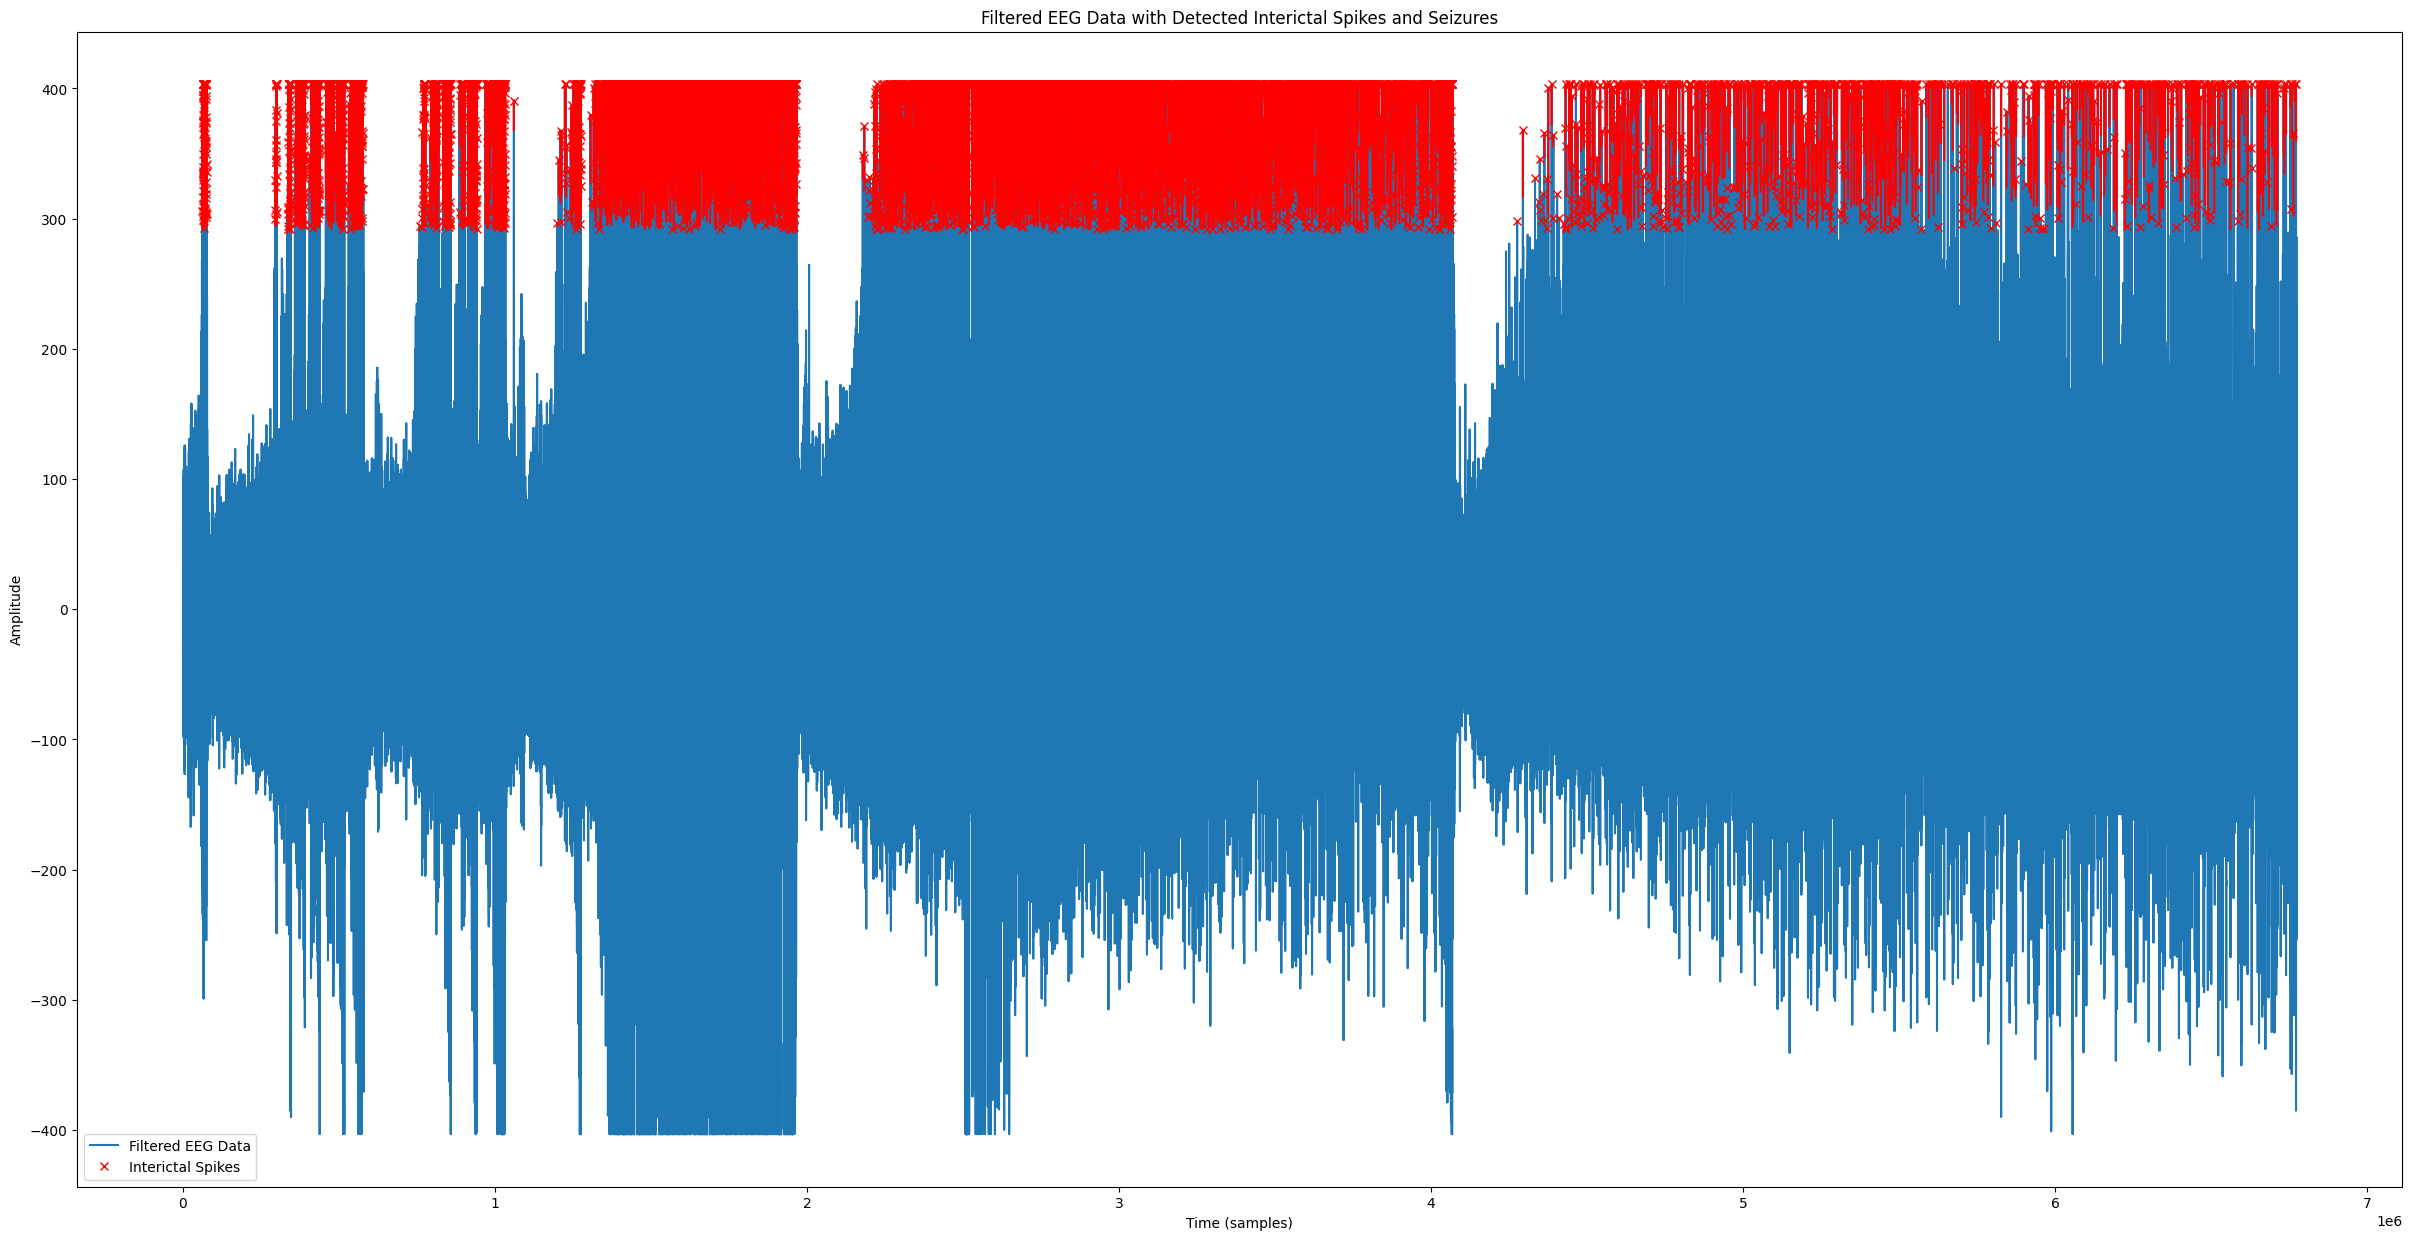

In [17]:
# Visualization
plt.figure(figsize=(30, 15))
plt.plot(filtered_data, label='Filtered EEG Data')

# Highlight seizure regions
for seizure in seizures:
    plt.plot(range(seizure[0], seizure[-1]), filtered_data[seizure[0]:seizure[-1]], color='red')

# Mark spikes
plt.plot(spikes, filtered_data[spikes], 'rx', label='Interictal Spikes')

plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Filtered EEG Data with Detected Interictal Spikes and Seizures')
plt.show()

Indices of positive spikes: [  60606   60900   60901 ... 6773302 6773828 6773829]
Indices of negative spikes: [  63457   63458   63957 ... 6773322 6773323 6773324]


/Users/pouya/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


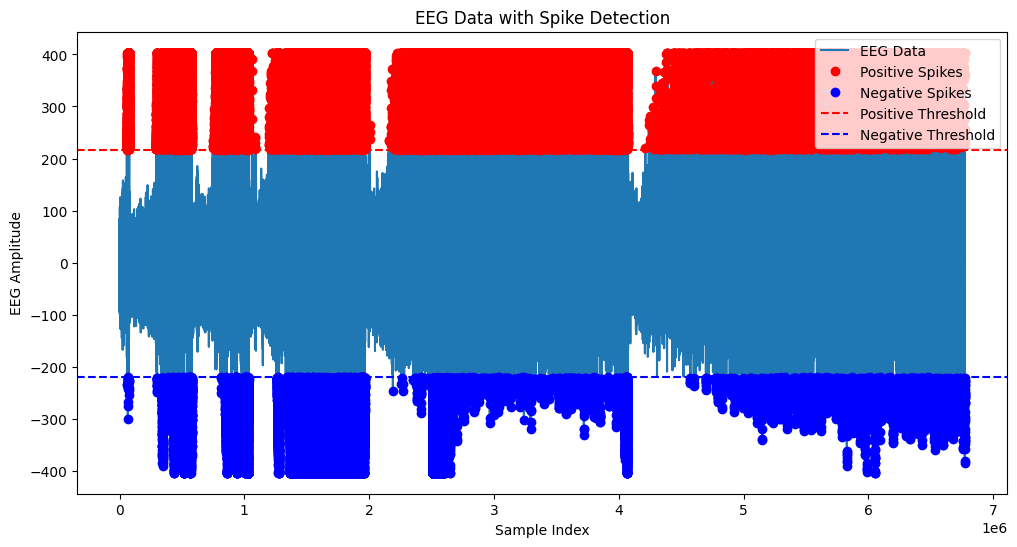

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Sample EEG data
# Replace this with your actual EEG data
eeg_data = dfs[6].values[:,0]
  # Example data, replace with actual EEG data

# Calculate the mean and standard deviation of the EEG data
mean = np.mean(eeg_data)
std_dev = np.std(eeg_data)

# Define the thresholds for spike detection
positive_threshold = mean + 3 * std_dev
negative_threshold = mean - 3 * std_dev

# Detect spikes
positive_spikes = eeg_data > positive_threshold
negative_spikes = eeg_data < negative_threshold

# Get the indices of the spikes
positive_spike_indices = np.where(positive_spikes)[0]
negative_spike_indices = np.where(negative_spikes)[0]

# Print spike indices
print("Indices of positive spikes:", positive_spike_indices)
print("Indices of negative spikes:", negative_spike_indices)

# Plot the EEG data and mark the spikes
plt.figure(figsize=(12, 6))
plt.plot(eeg_data, label='EEG Data')
plt.plot(positive_spike_indices, eeg_data[positive_spike_indices], 'ro', label='Positive Spikes')
plt.plot(negative_spike_indices, eeg_data[negative_spike_indices], 'bo', label='Negative Spikes')
plt.axhline(y=positive_threshold, color='r', linestyle='--', label='Positive Threshold')
plt.axhline(y=negative_threshold, color='b', linestyle='--', label='Negative Threshold')
plt.xlabel('Sample Index')
plt.ylabel('EEG Amplitude')
plt.title('EEG Data with Spike Detection')
plt.legend()
plt.show()
